In [2]:
using DifferentialEquations, DiffEqProblemLibrary, Plots
gr()

Plots.GRBackend()

# Plot solutions by each method

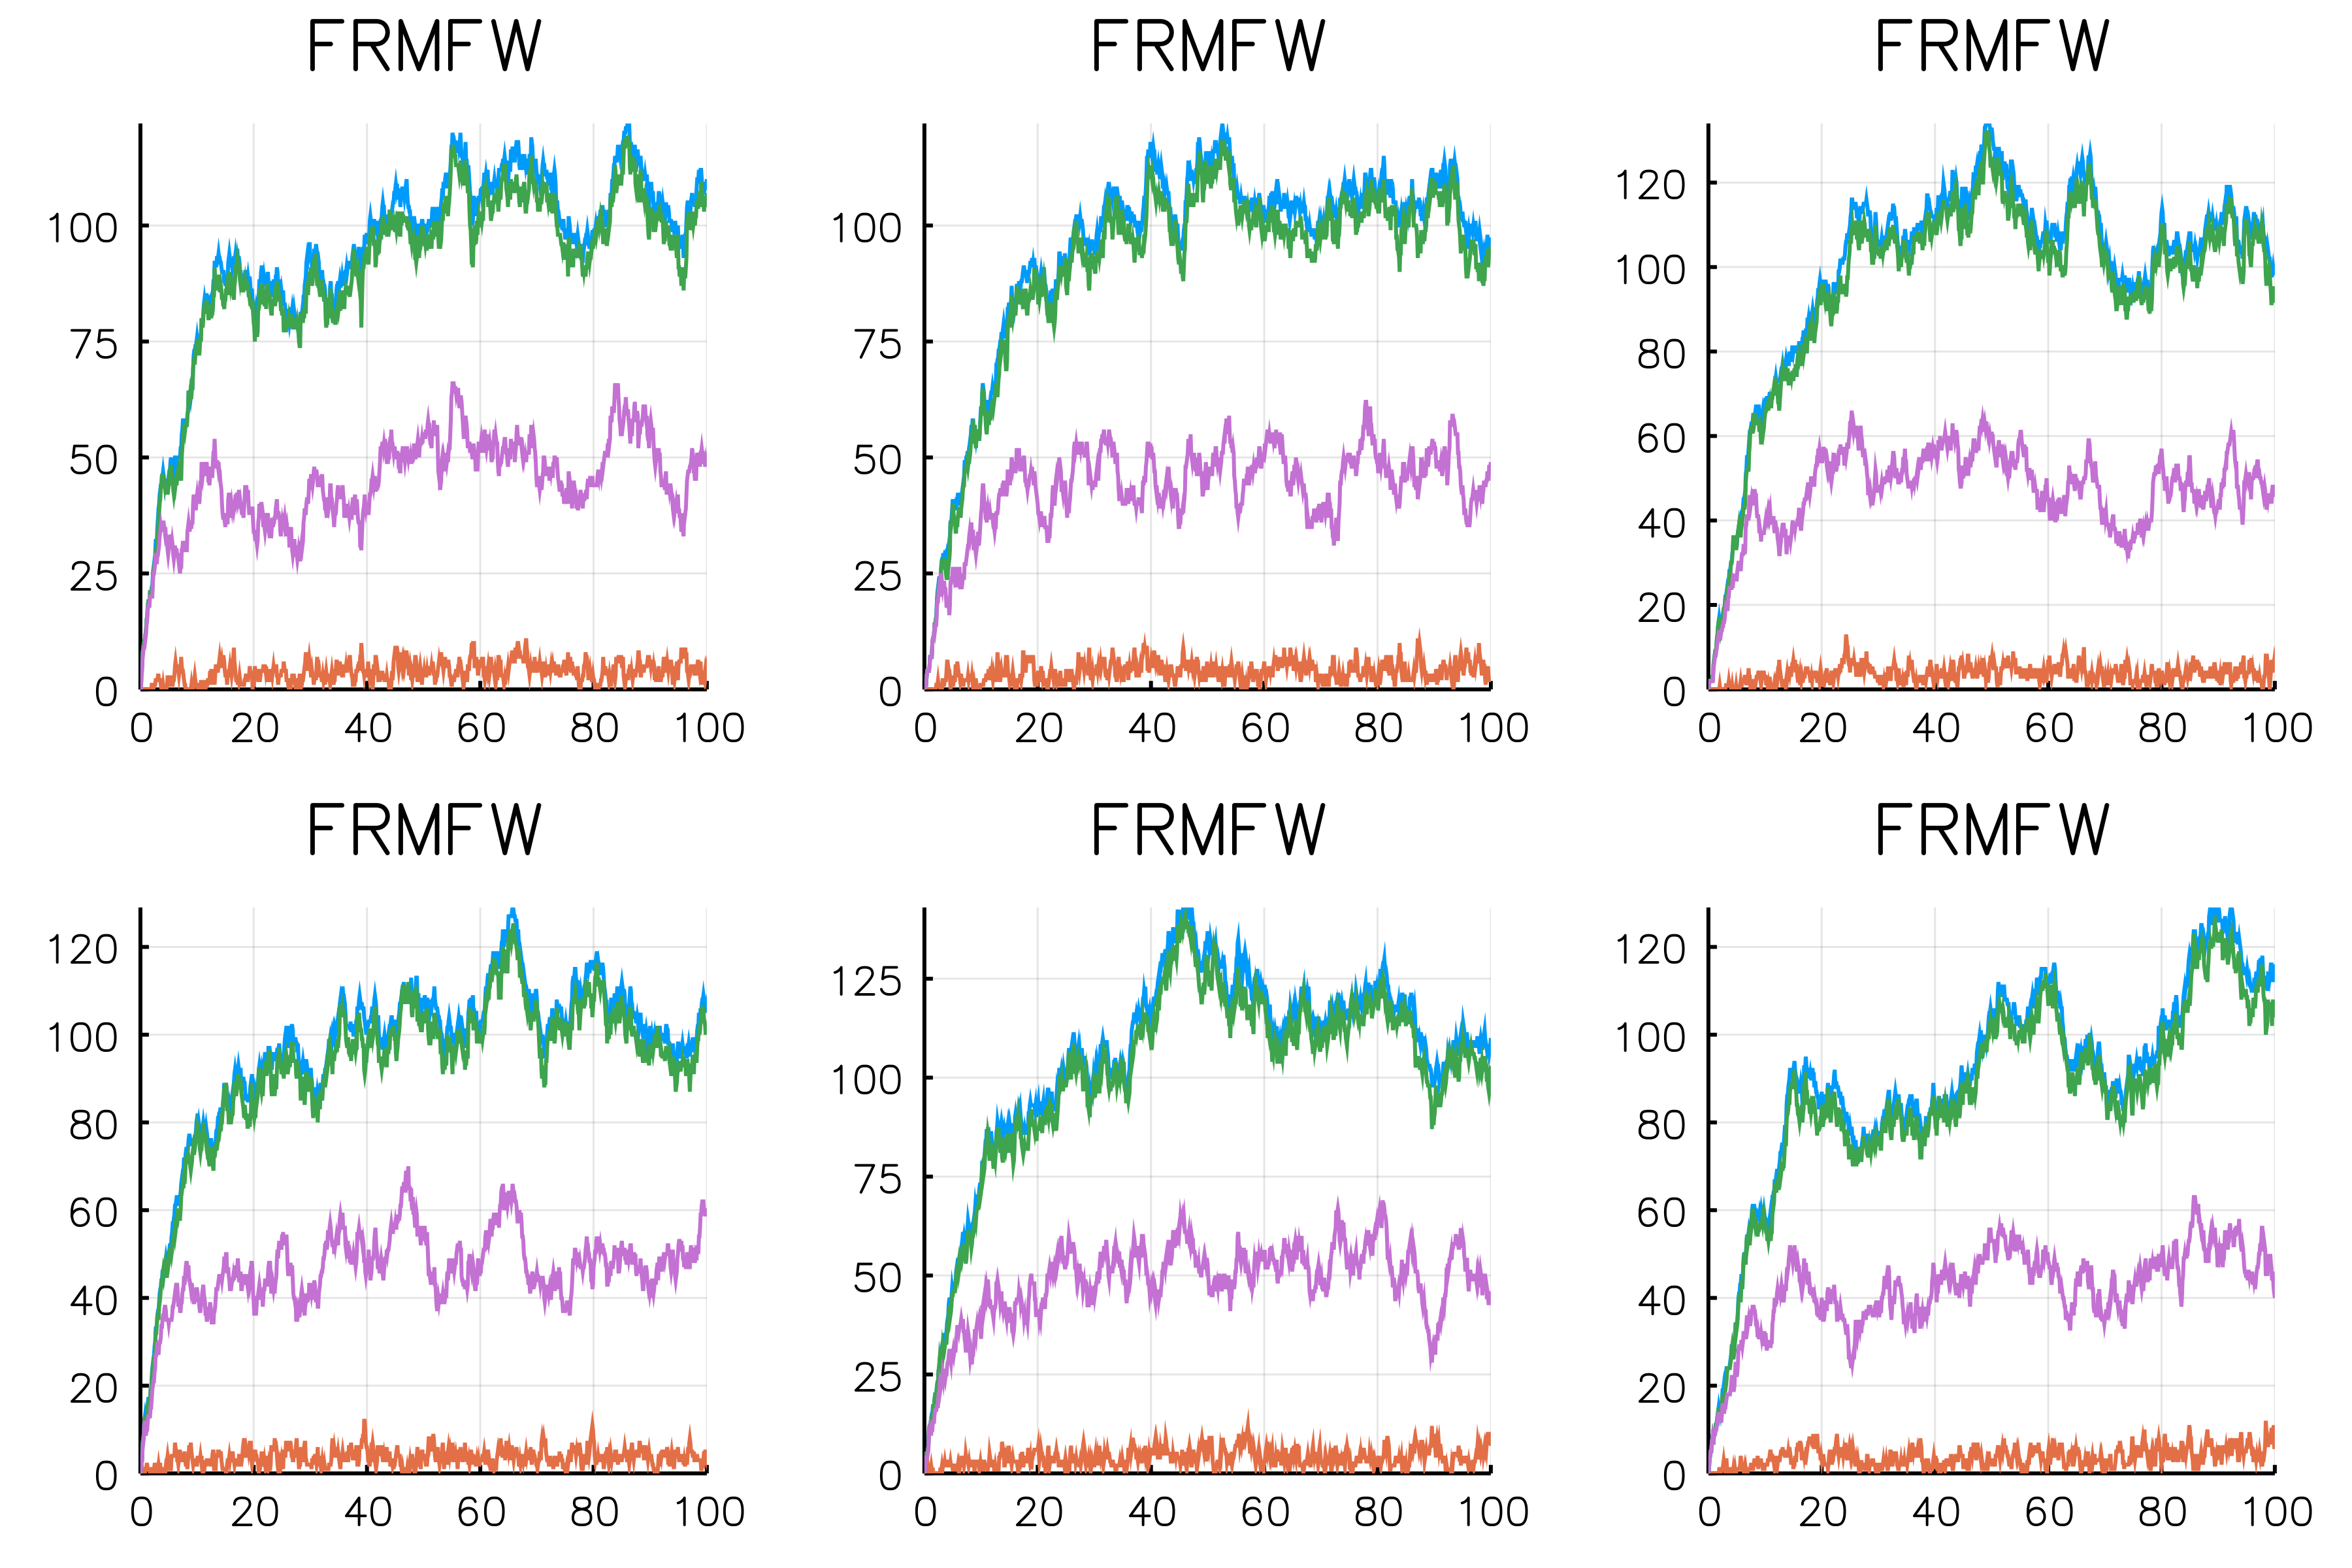

In [3]:
methods = (Direct(),DirectFW(),FRM(),FRMFW(),SortingDirect(),NRM())
legs    = [typeof(method) for method in methods]
shortlabels = [string(leg)[12:end] for leg in legs]
jprob   = prob_jump_multistate
prob    = jprob.discrete_prob
tf      = jprob.tstop
rn      = jprob.network
varlegs = ["A_P", "A_bound_P", "A_unbound_P", "RLA_P"]
varsyms = [
    [:S7,:S8,:S9], 
    [:S9],
    [:S7,:S8],
    [:S7]
]
varidxs = []
fmt = :png
for vars in varsyms
    push!(varidxs, [findfirst(rn.syms, sym) for sym in vars])
end
p = []
for (i,method) in enumerate(methods)
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper(), saveat=tf/1000.)
    solv = zeros(1001,4)
    for (i,varidx) in enumerate(varidxs)
        solv[:,i] = sum(sol[varidx,:],1)
    end
    if i < length(methods)
        push!(p, plot(sol.t,solv,title=shortlabels[i],legend=false,format=fmt))
    else
        push!(p, plot(sol.t,solv,title=shortlabels[i],legend=true,labels=varlegs,format=fmt))
    end
end
plot(p...,format=fmt)

# Benchmarking performance of the methods

In [8]:
using BenchmarkTools
benchmarks = []
# turn off saving solution
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper())
    push!(benchmarks, @benchmark (for i = 1:10; solve($jump_prob, $SSAStepper()); end))
end

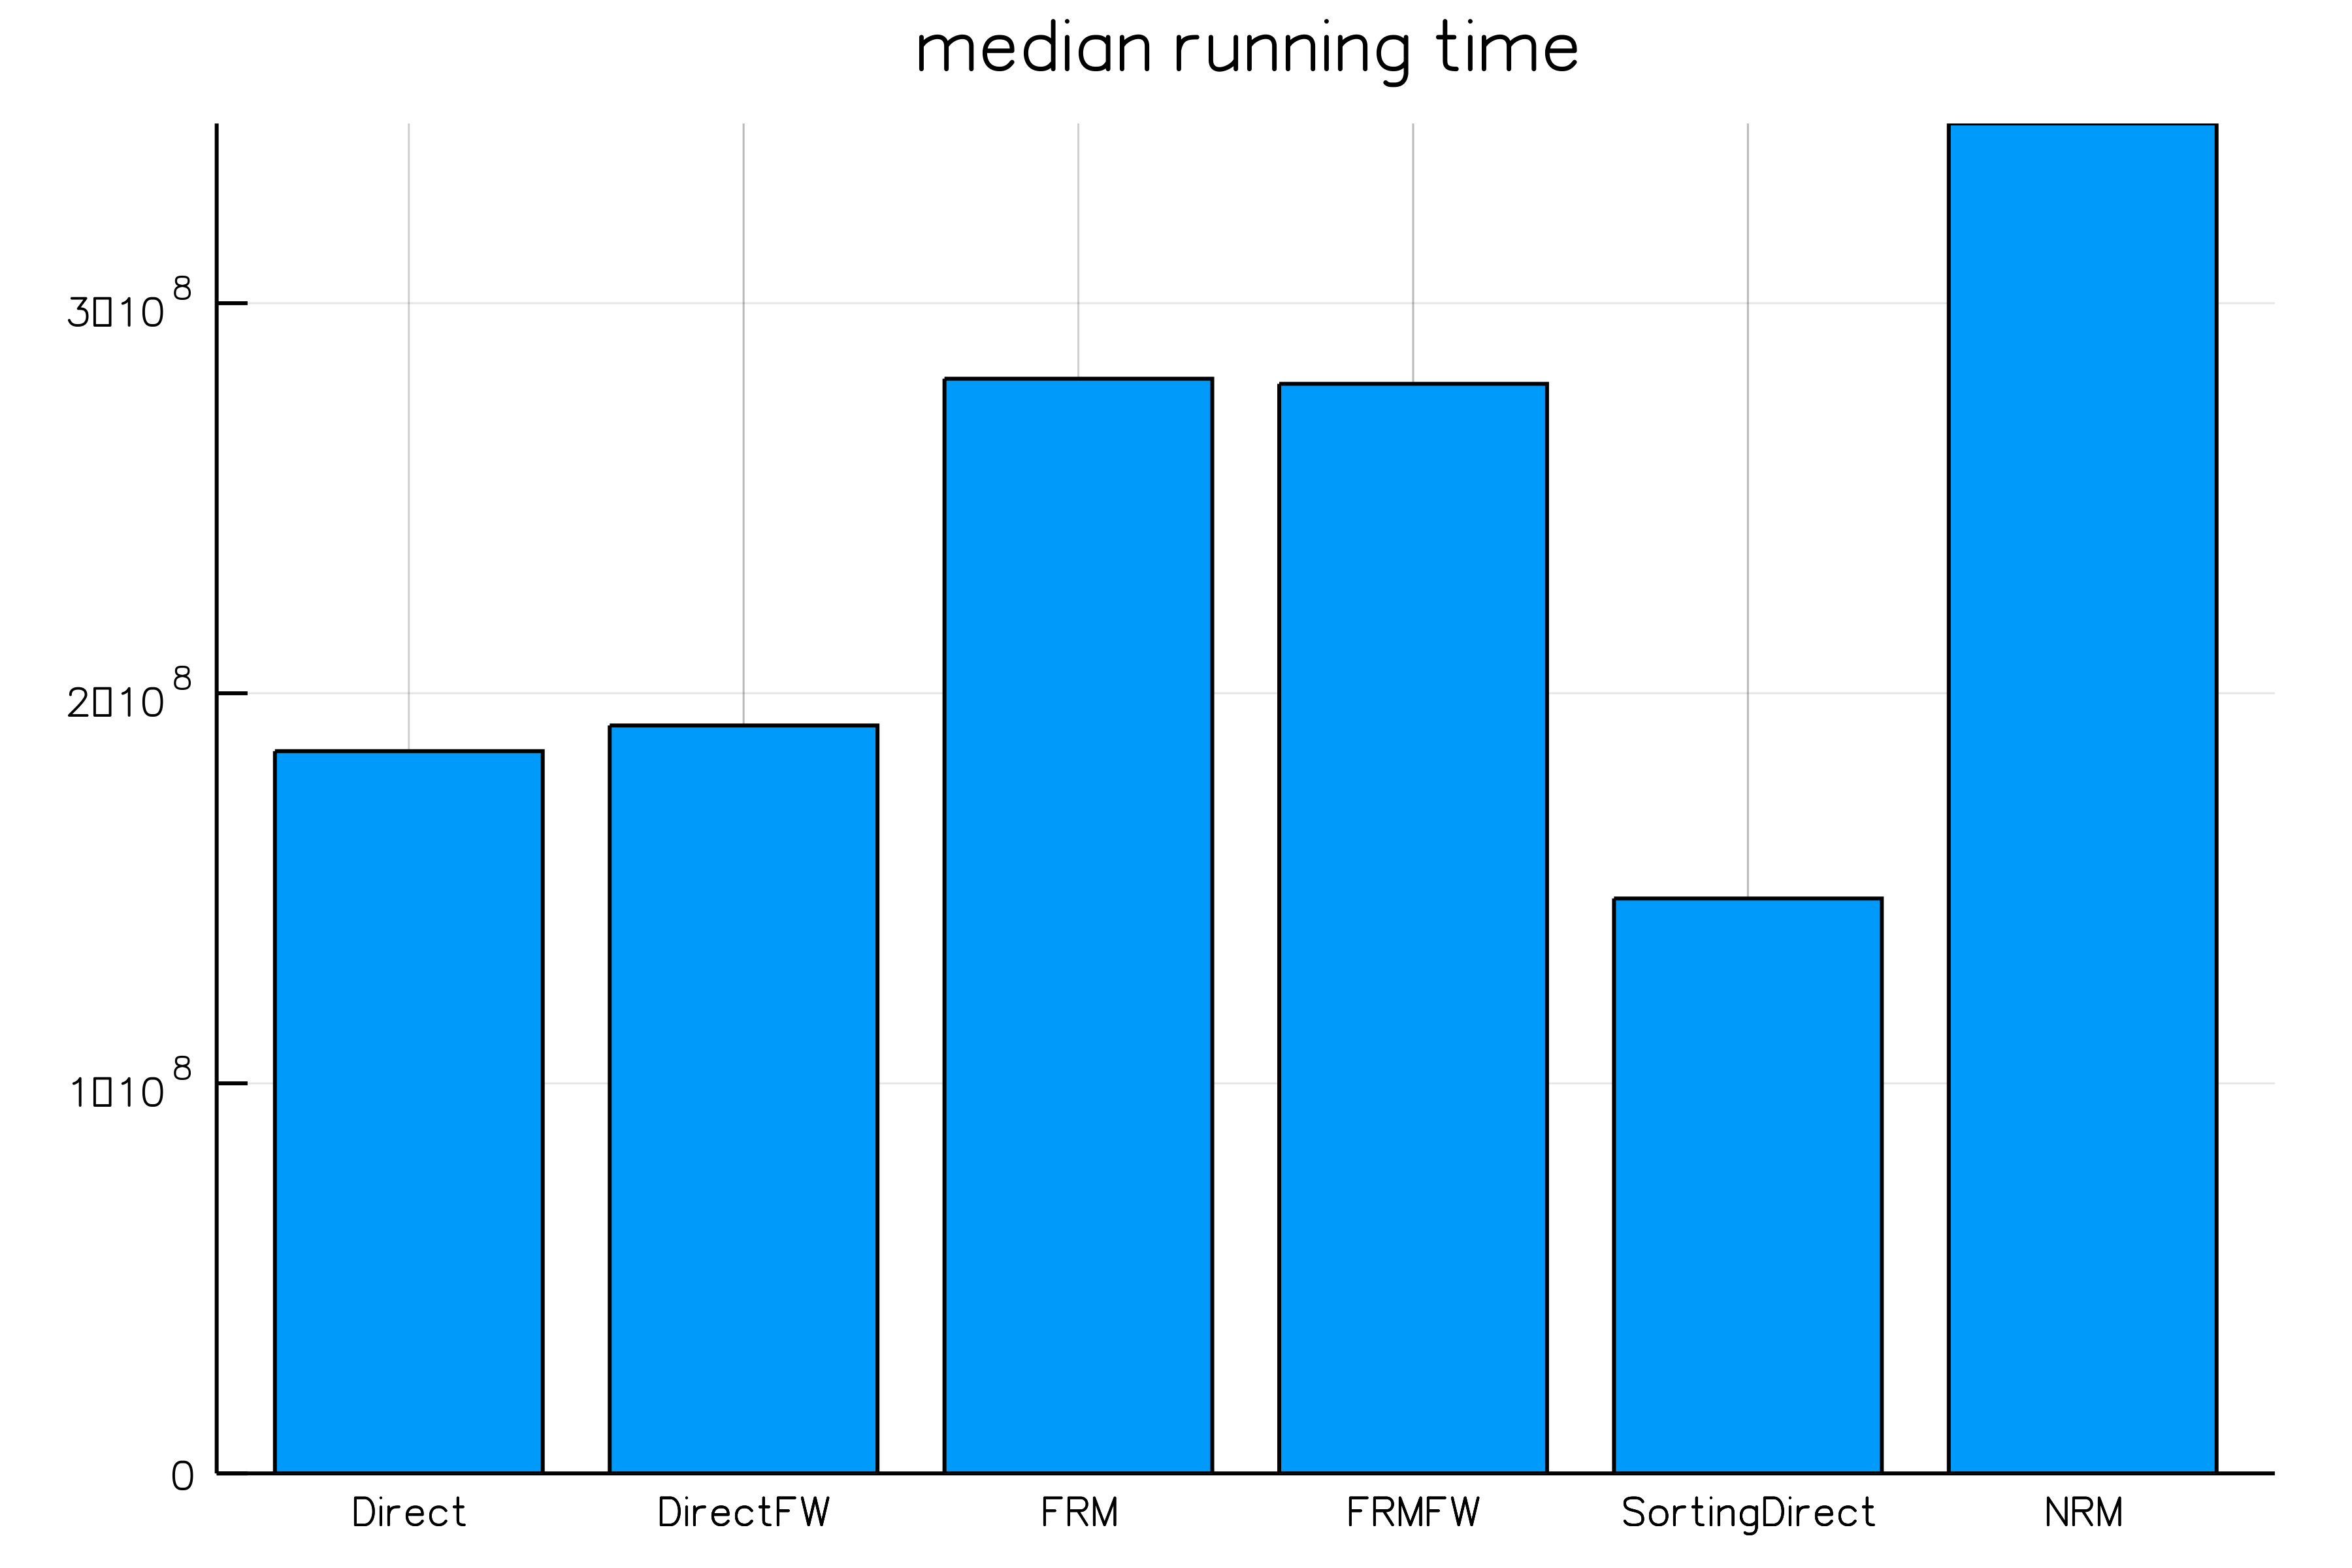

In [9]:
medtimes = [median(b.times) for b in benchmarks]
bar(shortlabels,medtimes,title="median running time",leg=false,format=fmt)

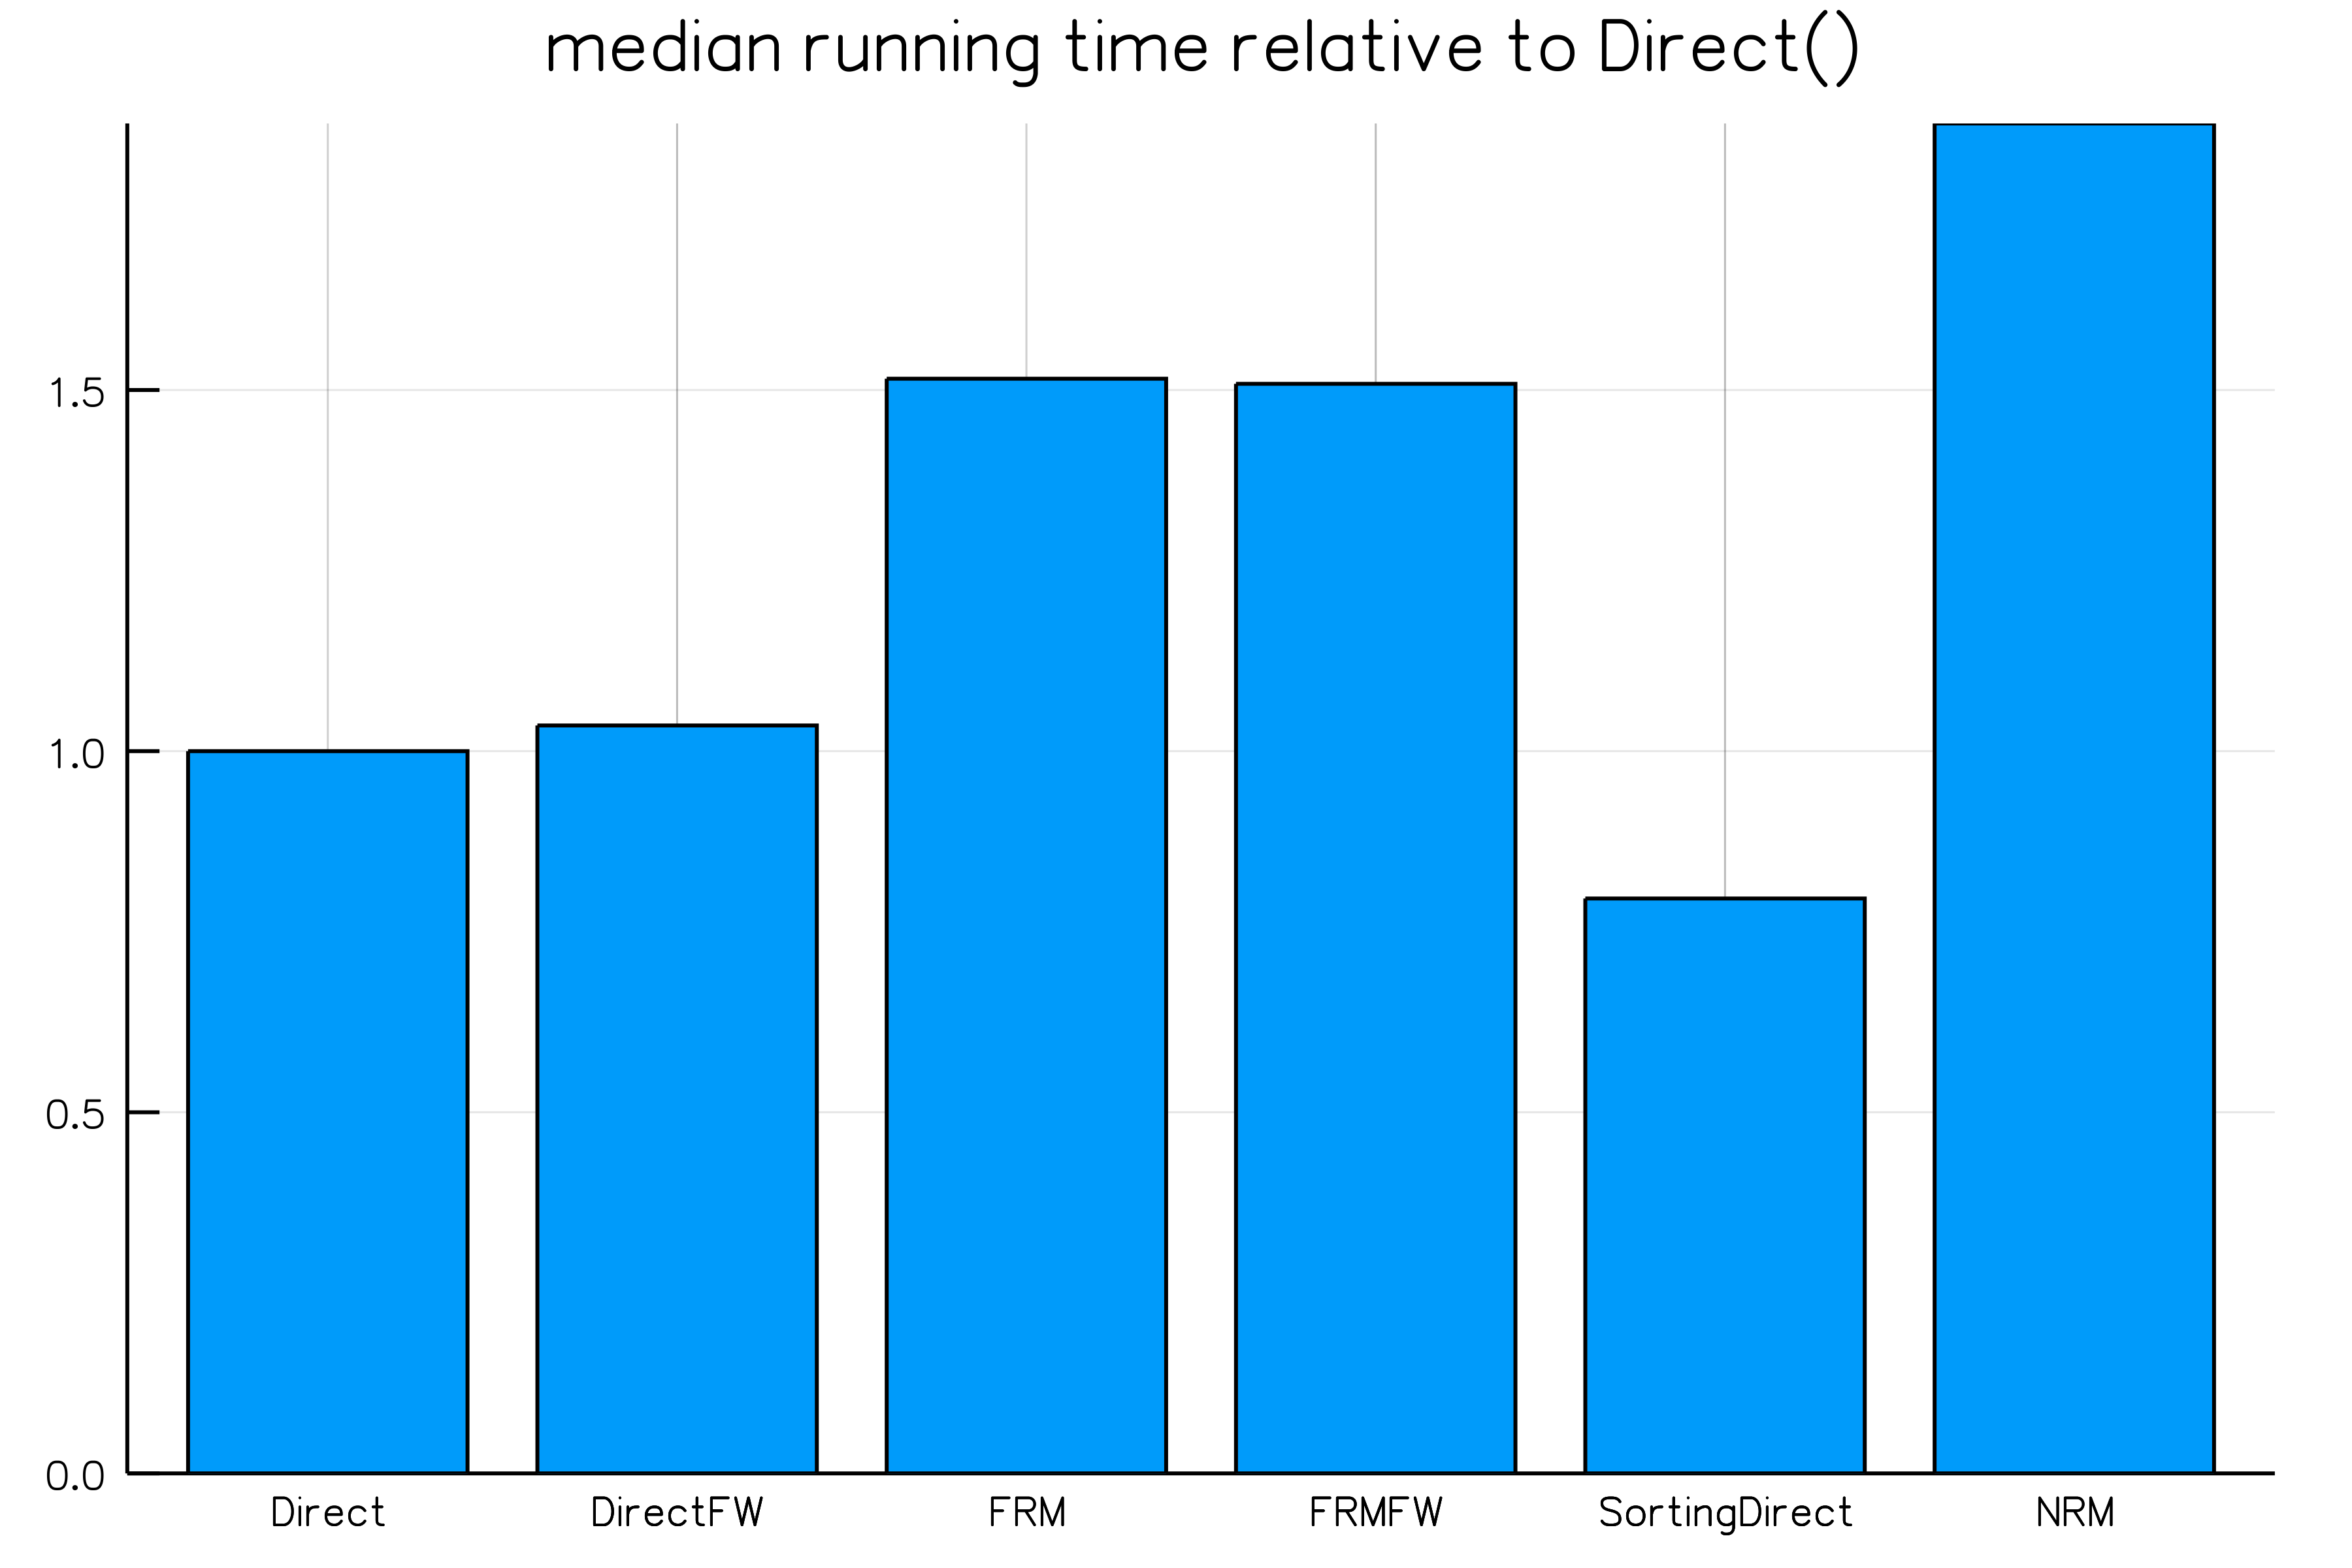

In [10]:
relmed = medtimes / medtimes[1]
bar(shortlabels,relmed,title="median running time relative to Direct()",leg=false,format=fmt)

In [11]:
using DataFrames
# convert times to units of ms
df = DataFrame(names=shortlabels,medtimes=(medtimes/1e6),relmedtimes=relmed)

6×3 DataFrames.DataFrame
│ Row │ names         │ medtimes │ relmedtimes │
├─────┼───────────────┼──────────┼─────────────┤
│ 1   │ Direct        │ 185.165  │ 1.0         │
│ 2   │ DirectFW      │ 191.752  │ 1.03558     │
│ 3   │ FRM           │ 280.647  │ 1.51566     │
│ 4   │ FRMFW         │ 279.334  │ 1.50857     │
│ 5   │ SortingDirect │ 147.387  │ 0.795979    │
│ 6   │ NRM           │ 346.08   │ 1.86904     │